<a href="https://colab.research.google.com/github/cavendano01/Statistical-Learning-II/blob/main/Anomaly-detection-%26-Dimensionality-reduction/SL_II_Practica_2_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2.1

## Imports

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn import metrics

from scipy.stats import multivariate_normal
from scipy.linalg import svd

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


1. Usando el dataset de estaturas(en google drive) aplicar detección de anomalías
 * Usar como training-set la primera pestaña “normales” (y=0)
 * La segunda pestaña “valtest(normales)” contiene datos normales(y=0):
    * Usar la mitad para cross-validation
    * Usar la mitad para testing
 * La tercera pestaña “valtest(anomalias)” contiene anomalías(y=1):
    * Usar la mitad para cross-validation 
    * Usar la mitad para testing
2. Los datos de cross-validation deben ser usados para selección de hyper-parámetros(por ejemplo el umbral epsilon) y/o selección de transformaciones a aplicar a las variables.
3. Usar los datos de testing para reportar las métricas de evaluación apropiadas
4. Es permitido usar librerías estadísticas(por ejemplo scipy.stats) para cosas como:
 * Estimación de parámetros(función de densidad)
 * Cálculo de densidades y/o probabilidades con la función de densidad estimada


## Data Loading

In [12]:
#Data Loading
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


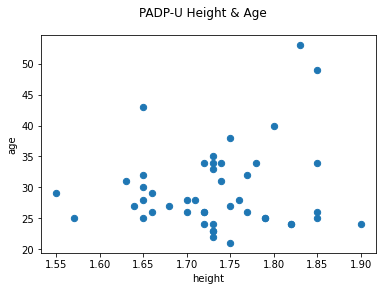

In [13]:
#Creating Heights Dataframe 
train = pd.read_excel("/content/drive/MyDrive/Statistical-Learning-II/practica-1/estaturas.xlsx","normales")
train.columns = ['Estatura', 'Edad']
train.head()
X = train.values
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis');
plt.suptitle('PADP-U Height & Age')
plt.xlabel('height')
plt.ylabel('age')
plt.show()

In [16]:
test = pd.read_excel("/content/drive/MyDrive/Statistical-Learning-II/practica-2/estaturas.xlsx","valtest(normales)")
test.columns = ['Estatura', 'Edad']
test.head()

,Estatura,Edad
0,1.82,25
1,1.80,27
2,1.60,31
3,1.60,35
4,1.82,30


In [17]:
anomalies = pd.read_excel("/content/drive/MyDrive/Statistical-Learning-II/practica-2/estaturas.xlsx","anomalias")
anomalies.columns = ['Estatura', 'Edad']
anomalies.head()

,Estatura,Edad
0,0.25,2.4
1,175.10,2.5
2,0.15,250.0
3,150.00,14.0


In [18]:
print(train.shape)
print(test.shape)
print(anomalies.shape)

(46, 2)
(8, 2)
(4, 2)


## Implementacion

In [19]:
test['label'] = 0
anomalies['label'] = 1

In [20]:
print(train.shape)
print(test.shape)
print(anomalies.shape)

(46, 2)
(8, 3)
(4, 3)


In [21]:
test = np.array_split(test.values, 2)
anomalies = np.array_split(anomalies.values, 2)

cvdata = np.vstack((test[0], anomalies[0]))
testset = np.vstack((test[1], anomalies[1]))

print(testset.shape)
print(cvdata.shape)

(6, 3)
(6, 3)


In [22]:
train.head()

,Estatura,Edad
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


## Implementation

In [33]:
def meanCov(x):
    mean = np.mean(x, axis = 0)
    covmatrix = np.cov(x.T)
    return mean, covmatrix

estimateDistribParams

In [34]:
def provX(x, mean, sigma):
    p = multivariate_normal(mean = mean, cov = sigma)
    probs = p.pdf(x)
    return probs

In [35]:
def anomalyDetection(probs, y, epsilon):
    yhat = np.piecewise(probs, [probs < epsilon, probs >= epsilon], [1, 0])
    f1_score = np.round(metrics.f1_score(y, yhat), 4)
    
    return yhat, f1_score

In [36]:
def selectTreshold(x, y, mean, sigma):
    probs = provX(x, mean, sigma)
    steps = (max(probs) - min(probs)) / 1000
    epsilon_grid = np.arange(min(probs), max(probs), steps)
    
    f1_scores = [anomalyDetection(probs, y, e)[1] for e in epsilon_grid]
    idx = np.argmax(f1_scores)
    
    print("Optimal treshold selected = {}".format(epsilon_grid[idx]))
    print("F1 Score obtained = {}".format(f1_scores[idx]))
    
    return epsilon_grid[idx], f1_scores[idx]

## Turning CrossValidation

In [37]:
mean, sdev = meanCov(train.values)
print(mean)
print(sdev)

[ 1.7326087  29.52173913]
[[5.67748792e-03 7.54975845e-02]
 [7.54975845e-02 4.50106280e+01]]


In [38]:
epsilon, score = selectTreshold(cvdata[:, :-1], cvdata[:, -1], mean, sdev)

Optimal treshold selected = 0.00018691176319452995
F1 Score obtained = 1.0


## Evaluation

In [39]:
preds, score = anomalyDetection(provX(testset[:, :-1], mean, sdev), testset[:, -1], 2)
print("F1 Score obtained = {}".format(score))

F1 Score obtained = 0.5


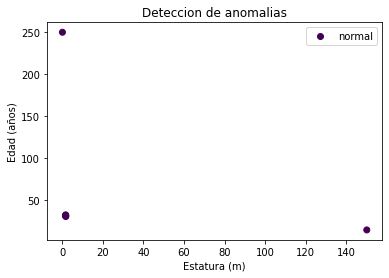

In [40]:
scatter = plt.scatter(x = testset[:, 0], y = testset[:, 1], c = preds)
plt.legend(handles = scatter.legend_elements()[0], labels = ['normal', 'anomaly'])
plt.title('Deteccion de anomalias')
plt.xlabel('Estatura (m)')
plt.ylabel('Edad (años)')
plt.show()

# Práctica 2.2

Usando el dataset de fashion MNIST realizar:
* PCA sin sklearn para reducir a 2 dimensiones.
  * Anotar la cantidad de varianza preservada.
* t-sne con sklearn para reducir a 2 dimensiones.
* Analizar ambas representaciones, comparar y concluir.
* Aplicar clustering con sklearn sobre la representación reducida. 
* Ya que este dataset si posee etiquetas “y” (tipo de prenda) analizar si los clusters encontrados tienden a agrupar el mismo tipo de prenda o prendas similares(por ejemplo se puede graficar cada tipo de diferente color)
* Agregar conclusiones finales. 


## Loading Data

In [69]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [70]:
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


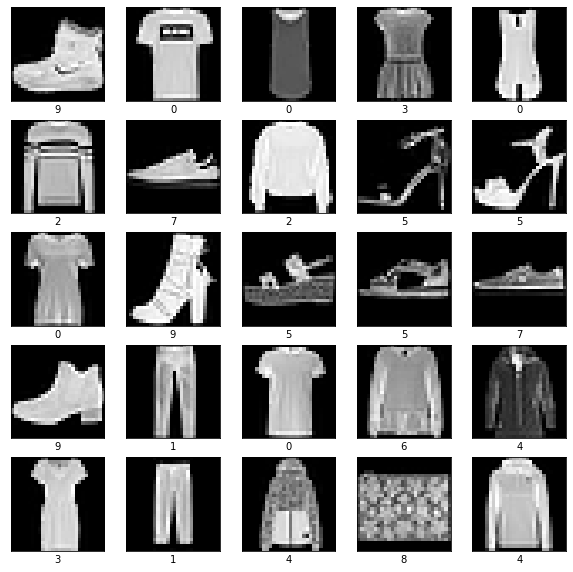

In [71]:
plt.figure(figsize=(10,10))

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap='gray')
  plt.xlabel(train_labels[i])
plt.show()

## PCA from Scratch

In [87]:
def PCAreduce(dataset):

  # 2d Rep of images
  dataset_2D = dataset.reshape(-1, dataset.shape[1] * dataset.shape[2]).astype(np.float32)

  #Mean, SD ,Normalization
  media = dataset_2D.mean(axis=0).reshape(1, dataset_2D.shape[1])
  sd = dataset_2D.std(axis=0).reshape(1, dataset_2D.shape[1])
  dataset_norm = (dataset_2D - media) / sd

  #matriz de covarianza
  sigma = np.cov(dataset_norm, rowvar = False)

  # Eigenvalues y Eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(sigma)

  # Sacar los indices en forma descendente
  sorted_index = np.argsort(eigen_values)[::-1]

  # Ordenar los Eigenvalues de forma descendente
  sorted_eigenvalue = eigen_values[sorted_index]

  # Ordenar los Eigenvectors de forma descendente
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  # Seleccionar las n features o componentes para nuestro dataset final reducido
  n_components = 2
  reduced_eigenvector = sorted_eigenvectors[:,0:n_components]

  data_reduced = np.matmul(reduced_eigenvector.T, dataset_norm.T).T
  data_reduced_df = pd.DataFrame(data_reduced, columns = ['dim1','dim2'])

  return data_reduced_df

In [88]:
PCAreduce_test= PCAreduce(test_images)
PCAreduce_test

,dim1,dim2
0,-16.812915,-7.211606
1,22.272422,-9.561988
2,3.924984,16.794861
3,-4.979121,16.840424
4,2.306644,0.354440
...,...,...
9995,-5.932131,-16.013942
9996,-11.599839,14.494540
9997,-6.940739,8.629278
9998,-2.835373,15.493484


## Visualization

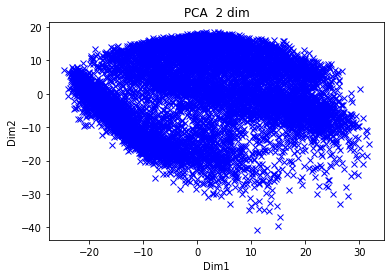

In [90]:
plt.plot(PCAreduce_test.iloc[:,0], PCAreduce_test.iloc[:,1], "bx")
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('PCA  2 dim')
plt.show()

## T-SNE con SKLEARN

In [91]:
test_images_2D = test_images.reshape(-1, test_images.shape[1] * test_images.shape[2]).astype(np.float32)

test_images_TSNE_reduced = TSNE(n_components=2, perplexity=50).fit_transform(test_images_2D)
test_images_TSNE_reduced = pd.DataFrame(test_images_TSNE_reduced, columns = ['dim1','dim2'])
test_images_TSNE_reduced

,dim1,dim2
0,-50.732662,9.073567
1,47.054314,35.075207
2,3.560402,-66.244972
3,-5.119819,-60.516098
4,15.693673,29.642769
...,...,...
9995,-46.991650,26.830454
9996,-5.909331,-53.106098
9997,-11.070394,21.728857
9998,-15.557332,-59.477386


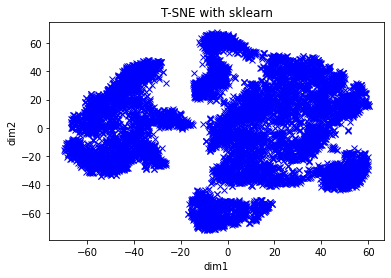

In [92]:
# Gráfica de los datos reducidos a 2 dimensiones

plt.plot(test_images_TSNE_reduced.iloc[:,0], test_images_TSNE_reduced.iloc[:,1], "bx")
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('T-SNE with sklearn')
plt.show()

### Clustered

In [100]:
def GMMplot(gmm, dataset):
  clusters = gmm.predict(dataset)
  labels = ["cluster1", "cluster2", "cluster3", "cluster4" , "cluster5", "cluster6", "cluster7", "cluster8", "cluster9", "cluster10"]
  plt.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=clusters)
  plt.scatter(gmm.means_[:,0], gmm.means_[:,1], s=100, c="red", label="Centroids")
  plt.xlabel("dim1")
  plt.ylabel("dim2")
  plt.title("CLUSTERED DATA WITH GMM")
  plt.legend()
  plt.show()

### PCA in SKLEARN

In [101]:
from sklearn.mixture import GaussianMixture

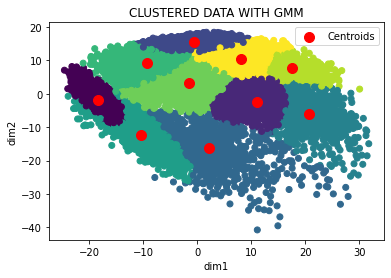

In [102]:
gmm_PCA = GaussianMixture(n_components=10, random_state=0).fit(test_images_PCA_reduced)

GMMplot(gmm_PCA, PCAreduce_test)

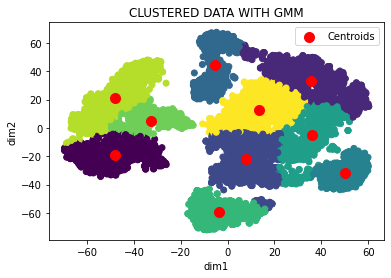

In [103]:
gmm_TSNE = GaussianMixture(n_components=10, random_state=0).fit(test_images_TSNE_reduced)

GMMplot(gmm_TSNE, test_images_TSNE_reduced)

## Conclusión

PCA se desempeña mejor que TSNE en tiempo de procesamiento, con TSNE siendo lento incluso con solo el test dataset (1000 samples) en un ambiente de producción esto generaría un costo de tiempo al entrenar el modelo. Sin embargo, las features creadas con GMM tienen fronteras más claras